<a href="https://colab.research.google.com/github/Tombellens/lipar-data-clean-analysis/blob/main/Copy_of_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
from collections import Counter

positions_df = pd.read_csv('/content/drive/My Drive/merged_positions_progress.csv', sep=';')
individuals_df = pd.read_csv ('/content/drive/My Drive/aggregated_ministry_position_ids.csv')
individuals_df_edu = pd.read_csv ('/content/drive/My Drive/individuals_df.csv')
prev_next_df = pd.read_csv('/content/drive/My Drive/positions_prev_next.csv', sep=";")
full_positions_df = pd.read_csv('/content/drive/My Drive/all_positions.csv', sep=";")
educations_df = pd.read_csv('/content/drive/My Drive/full_educations.csv')
ministries_df = pd.read_csv('/content/drive/My Drive/ministries.csv', sep=";", encoding='latin-1', encoding_errors='replace')

# 0. Basic descriptives

Totaal van individuele adviseurs geidentificeerd over de periode 1999 tot 2020:


In [ ]:
num_individuals = individuals_df.shape[0]
print(num_individuals)


754


Totaal van de carriereposities gekoppeld aan deze adviseurs die we gevonden hebben:

In [ ]:
num_positions = full_positions_df.shape[0]
print(num_positions)

5828


Totaal aantal ministers en ministers per partij

In [ ]:
# prompt: use the ministries_df to count the number of unique minister gov combinations. make a df of this that also includes the party column. Also count the number of unique ministers in the minister column


minister_gov_counts = ministries_df.groupby(['minister', 'gov'])['party'].agg('first').reset_index()
print(minister_gov_counts)
min_gov_counts =minister_gov_counts['party'].value_counts()

# Count unique ministers
num_unique_ministers = ministries_df['minister'].nunique()
print("Number of unique ministers:", num_unique_ministers)


              minister  gov  party
0   Adelheid BYTTEBIER    2  GROEN
1   Annemie TURTELBOOM    6    VLD
2          Bart SOMERS    2    VLD
3          Bart SOMERS    8    VLD
4       Bart TOMMELEIN    6    VLD
..                 ...  ...    ...
67       Veerle HEEREN    4    CDV
68            Vera DUA    1  Groen
69         Wouter BEKE    8    CDV
70        Yves LETERME    3    CDV
71         Zuhal DEMIR    8    NVA

[72 rows x 3 columns]
Number of unique ministers: 48


In [ ]:
positions_df

Totaal van de carriereposities in een Vlaams ministerieel kabinet. Adviseurs bekleden regelmatig meerdere kabinetsposities in hun carriere:

In [ ]:
num_cabinet_positions = positions_df.shape[0]
print(num_cabinet_positions)

1245


Gemiddeld aantal regeringen gediend per ministerieel adviseur

In [ ]:
print(individuals_df['gov_status'].value_counts())


def normalize_govs(gov):
    if isinstance(gov, str):
        govs = re.split(r'\s*,\s*', gov)
        return [g for g in govs if g != 'unknown']
    return []

# Function to count the distribution of the number of unique governments
def count_gov_distribution(df):
    df['normalized_govs'] = df['gov'].apply(normalize_govs)
    df['num_govs'] = df['normalized_govs'].apply(len)
    distribution = Counter(df['num_govs'])
    return distribution

# Apply the function and get the distribution
gov_distribution = count_gov_distribution(individuals_df)

# Display the distribution
print(gov_distribution)

gov_status
singular    510
mixed       244
Name: count, dtype: int64
Counter({1: 510, 2: 183, 3: 50, 4: 9, 6: 2})


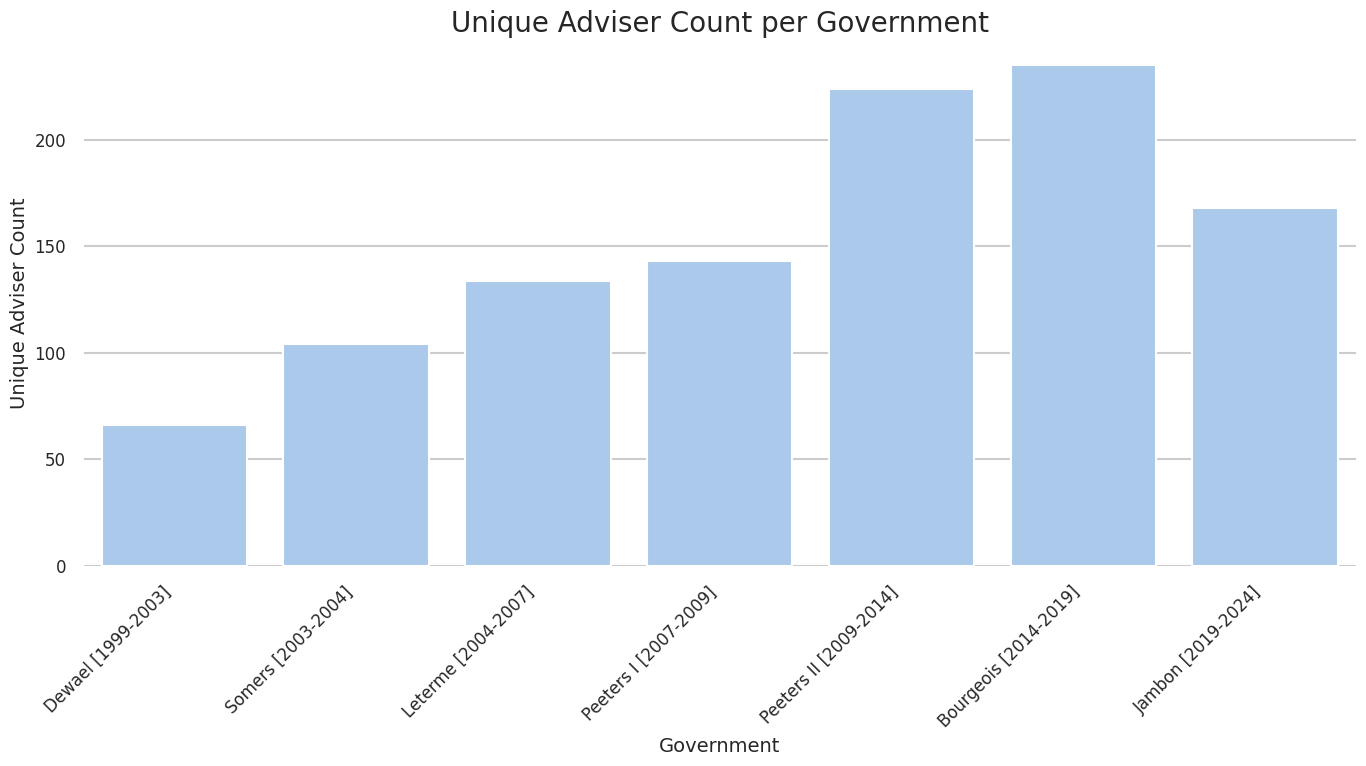

In [ ]:
import ast

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode the 'gov' column to create separate rows for each government
exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)

# Exclude rows where gov is 'unknown'
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']

# Drop duplicates to keep unique adviser_id - gov combinations
unique_advisers_per_gov = exploded_gov_df[['adviser_id', 'gov']].drop_duplicates()

# Set the order and labels for the governments
gov_order = [1, 2, 3, 4, 5, 6, 8]
gov_labels = ['Dewael [1999-2003]', 'Somers [2003-2004]', 'Leterme [2004-2007]', 'Peeters I [2007-2009]',
              'Peeters II [2009-2014]', 'Bourgeois [2014-2019]', 'Jambon [2019-2024]']

# Plotting the count distribution per government
sns.set(style='whitegrid', context='talk')

cubehelix_color = sns.color_palette("pastel")[0]

plt.figure(figsize=(14, 8))
sns.countplot(data=unique_advisers_per_gov, x='gov', order=gov_order, color=cubehelix_color)
plt.title('Unique Adviser Count per Government', fontsize=20)
plt.xlabel('Government', fontsize=14)
plt.ylabel('Unique Adviser Count', fontsize=14)
plt.xticks(ticks=range(len(gov_labels)), labels=gov_labels, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plt.savefig('/content/drive/My Drive/Unique_Adviser_Count_per_Government.png')

# Show the plot
plt.show()

In [ ]:
unique_advisers_per_gov['gov'].value_counts()

,count
gov,
6,235
5,224
8,168
4,143
3,134
2,104
1,66


In [ ]:
import ast

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

# Convert 'party' and 'gov' columns to lists
positions_df['party'] = positions_df['party'].apply(convert_to_list)
positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode both 'party' and 'gov' columns to create separate rows for each combination
exploded_df = positions_df.explode('party').explode('gov').reset_index(drop=True)

# Exclude rows where party or government is 'unknown'
exploded_df = exploded_df[(exploded_df['party'] != 'unknown') & (exploded_df['gov'] != 'unknown')]

# Drop duplicates to keep unique adviser_id - government - party combinations
unique_advisers_per_party_gov = exploded_df[['adviser_id', 'gov', 'party']].drop_duplicates()

# Count the unique adviser-government pairs per party
party_gov_counts = unique_advisers_per_party_gov.groupby('party')['gov'].nunique().reindex(['CD&V', "Open VLD", "N-VA", "Vooruit / sp.a", "Groen", "VU"]).fillna(0).astype(int)

# Create a table displaying the count per party
party_gov_table = pd.DataFrame(party_gov_counts).reset_index()
party_gov_table.columns = ['Party', 'Unique Adviser-Government Pairs Count']

# Display the table
print(party_gov_table)


            Party  Unique Adviser-Government Pairs Count
0            CD&V                                      0
1        Open VLD                                      0
2            N-VA                                      0
3  Vooruit / sp.a                                      0
4           Groen                                      0
5              VU                                      0


In [ ]:
unique_advisers_per_party_gov['party'].value_counts()

,count
party,
cdv,363
vld,262
nva,259
spa,187
groen,40
vu,9


The distribution of different types of positions over time.

In [ ]:
import ast

# Assuming you have a CSV file named 'positions.csv' with your data
# If the file is in a different location or has a different name, adjust the path accordingly
def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

# Convert 'gov' column to list
positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode the 'gov' column to create separate rows for each government
exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)

# Exclude rows where gov is 'unknown'
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']

# Create the global distribution
global_rank_distribution = positions_df['rank'].value_counts(normalize=True).sort_index()

# Create the distribution per government
gov_rank_distribution = exploded_gov_df.groupby('gov')['rank'].value_counts(normalize=True).unstack(fill_value=0)

# Define the order and labels for the governments
gov_order = [1, 2, 3, 4, 5, 6, 8]
gov_labels = ['Dewael [1999-2003]', 'Somers [2003-2004]', 'Leterme [2004-2007]', 'Peeters I [2007-2009]',
              'Peeters II [2009-2014]', 'Bourgeois [2014-2019]', 'Jambon [2019-2024]']

# Reorder the columns to match the government order
gov_rank_distribution = gov_rank_distribution.reindex(columns=sorted(gov_rank_distribution.columns))
gov_rank_distribution = gov_rank_distribution.reindex(gov_order)

# Create a dictionary to map government numbers to labels
gov_label_dict = dict(zip(gov_order, gov_labels))

# Rename the index with the government labels
gov_rank_distribution.index = gov_rank_distribution.index.map(gov_label_dict)

# Add the global distribution as the last row
gov_rank_distribution.loc['Global'] = global_rank_distribution

# Convert to percentages
gov_rank_distribution = gov_rank_distribution * 100

# Round to two decimal places
gov_rank_distribution = gov_rank_distribution.round(2)

# Display the table
print(gov_rank_distribution)

rank                     CoS  adviser  media  minister  nonMC  other  \
gov                                                                    
Dewael [1999-2003]      1.35    54.05   6.76      1.35   0.00  27.03   
Somers [2003-2004]      5.66    51.89   4.72      0.00   0.94  28.30   
Leterme [2004-2007]     5.07    50.72   4.35      0.00   0.72  28.99   
Peeters I [2007-2009]   4.70    53.02   4.70      0.00   0.00  29.53   
Peeters II [2009-2014]  5.43    61.63   6.59      0.00   0.39  14.73   
Bourgeois [2014-2019]   6.71    53.99   6.71      0.00   0.96  18.21   
Jambon [2019-2024]      3.63    55.96   7.25      0.00   0.52  16.58   
Global                  5.38    53.25   6.51      0.72   0.88  21.69   

rank                    secretary  viceCoS  
gov                                         
Dewael [1999-2003]           0.00     9.46  
Somers [2003-2004]           0.00     8.49  
Leterme [2004-2007]          0.00    10.14  
Peeters I [2007-2009]        0.67     7.38  
Peeters I

# 1. Gender

Globaal genomen is de man vrouw verhouding:


In [ ]:
individuals_df['probability_male'].dropna().mean()

0.6095448634100438

Voor een aantal individuen kon geen inschatting worden gemaakt



In [ ]:
individuals_df['probability_male'].isna().sum()

20

Echter wanneer we kijken per categorie zien we een hierarchische verdeling, die verder gaat ten nadele van vrouwelijke kabinetsmedewerkers hoe hoger in rang



In [ ]:
positions_df.groupby('mapped_rank')['probability_male'].mean()

,probability_male
mapped_rank,
1,0.509528
2,0.607250
3,0.761179


Ook over tijd verandert de verdeling lichtjes:

In [ ]:
import ast

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

positions_df['gov'] = positions_df['gov'].apply(convert_to_list)
positions_df.explode('gov').reset_index(drop=True)

exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']
unique_advisers_per_party_gov = exploded_gov_df[['adviser_id', 'gov', 'party', 'probability_male']].drop_duplicates()

unique_advisers_per_party_gov.groupby('gov')['probability_male'].mean().to_frame()

,probability_male
gov,
1,0.612661
2,0.677600
3,0.607451
4,0.580641
5,0.645800
6,0.584698
8,0.626043


In [ ]:
# prompt: take this one but give us probability_female by subtracting it from one : unique_advisers_per_party_gov.groupby('gov')['probability_male'].mean().to_frame()

(1 - unique_advisers_per_party_gov.groupby('gov')['probability_male'].mean()).to_frame().to_latex()


'\\begin{tabular}{lr}\n\\toprule\n & probability_male \\\\\ngov &  \\\\\n\\midrule\n1 & 0.387339 \\\\\n2 & 0.322400 \\\\\n3 & 0.392549 \\\\\n4 & 0.419359 \\\\\n5 & 0.354200 \\\\\n6 & 0.415302 \\\\\n8 & 0.373957 \\\\\n\\bottomrule\n\\end{tabular}\n'

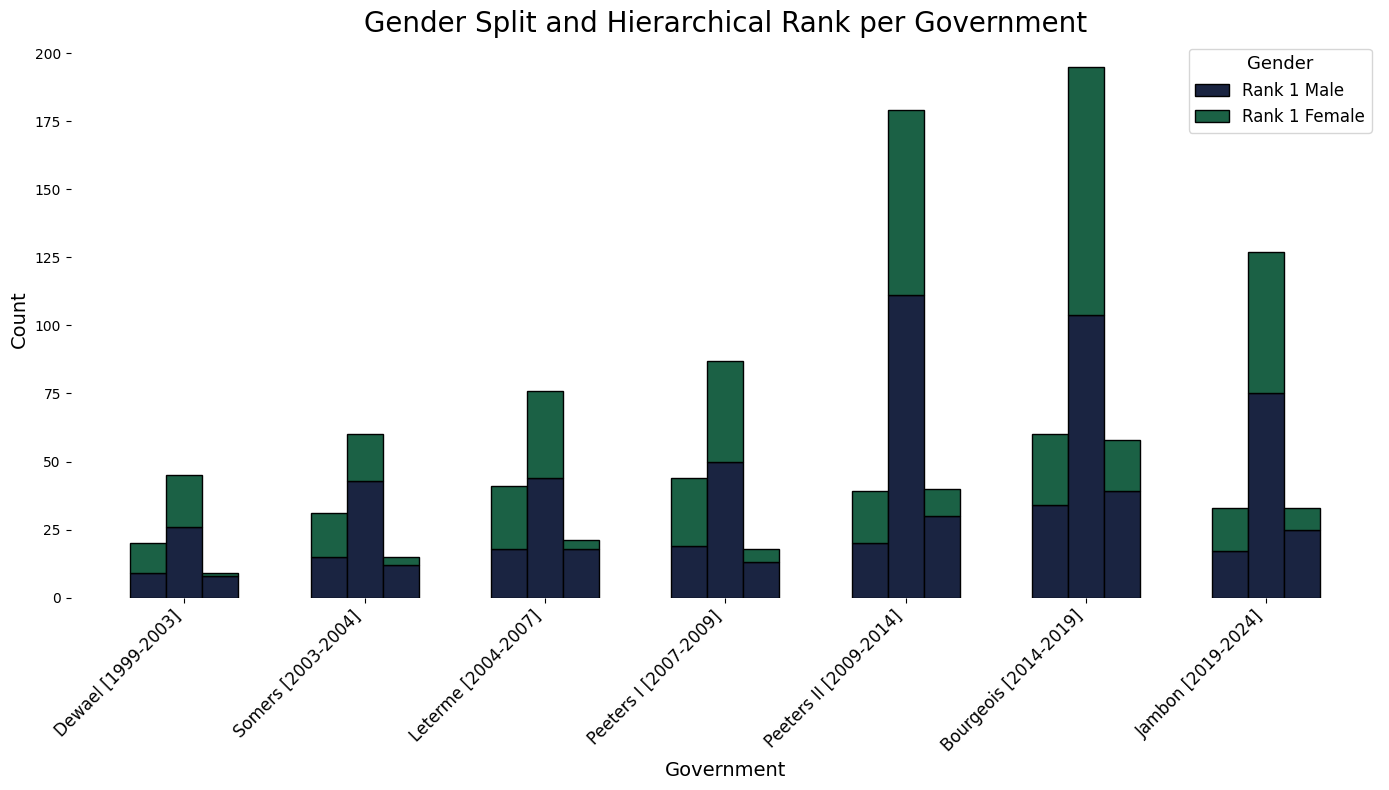

In [ ]:
import ast

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode the 'gov' column
exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']

# Recode 'male_probability' to 'gender'
exploded_gov_df['gender'] = exploded_gov_df['probability_male'].apply(lambda x: 'Male' if x > 0.5 else 'Female')

# Define custom order and labels for governments
gov_order = [1, 2, 3, 4, 5, 6, 8]
gov_labels = ['Dewael [1999-2003]', 'Somers [2003-2004]', 'Leterme [2004-2007]', 'Peeters I [2007-2009]', 'Peeters II [2009-2014]', 'Bourgeois [2014-2019]', 'Jambon [2019-2024]']

# Prepare data for plotting
plot_data = exploded_gov_df.groupby(['gov', 'mapped_rank', 'gender']).size().unstack(fill_value=0).reset_index()

# Initialize the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define bar width and positions
bar_width = 0.2
gov_positions = list(range(len(gov_labels)))
bar_positions = [x + bar_width * i for x in gov_positions for i in range(3)]

# Colors for gender
colors = {'Male': sns.color_palette("cubehelix")[0], 'Female': sns.color_palette("cubehelix")[1]}

# Plot each rank
for i, rank in enumerate(sorted(plot_data['mapped_rank'].unique())):
    rank_data = plot_data[plot_data['mapped_rank'] == rank]
    male_counts = rank_data['Male'].values if 'Male' in rank_data.columns else [0] * len(rank_data)
    female_counts = rank_data['Female'].values if 'Female' in rank_data.columns else [0] * len(rank_data)

    bar_pos = [pos + bar_width * i for pos in gov_positions]

    ax.bar(bar_pos, male_counts, bar_width, label=f'Rank {rank} Male' if i == 0 else "", color=colors['Male'], edgecolor='black')
    ax.bar(bar_pos, female_counts, bar_width, bottom=male_counts, label=f'Rank {rank} Female' if i == 0 else "", color=colors['Female'], edgecolor='black')

# Customizing the plot
ax.set_title('Gender Split and Hierarchical Rank per Government', fontsize=20)
ax.set_xlabel('Government', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks([r + bar_width for r in range(len(gov_labels))])
ax.set_xticklabels(gov_labels, rotation=45, ha='right', fontsize=12)
ax.legend(title='Gender', fontsize=12, title_fontsize='13')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Gender_Hierarchical_Split_per_Government.png')
plt.show()

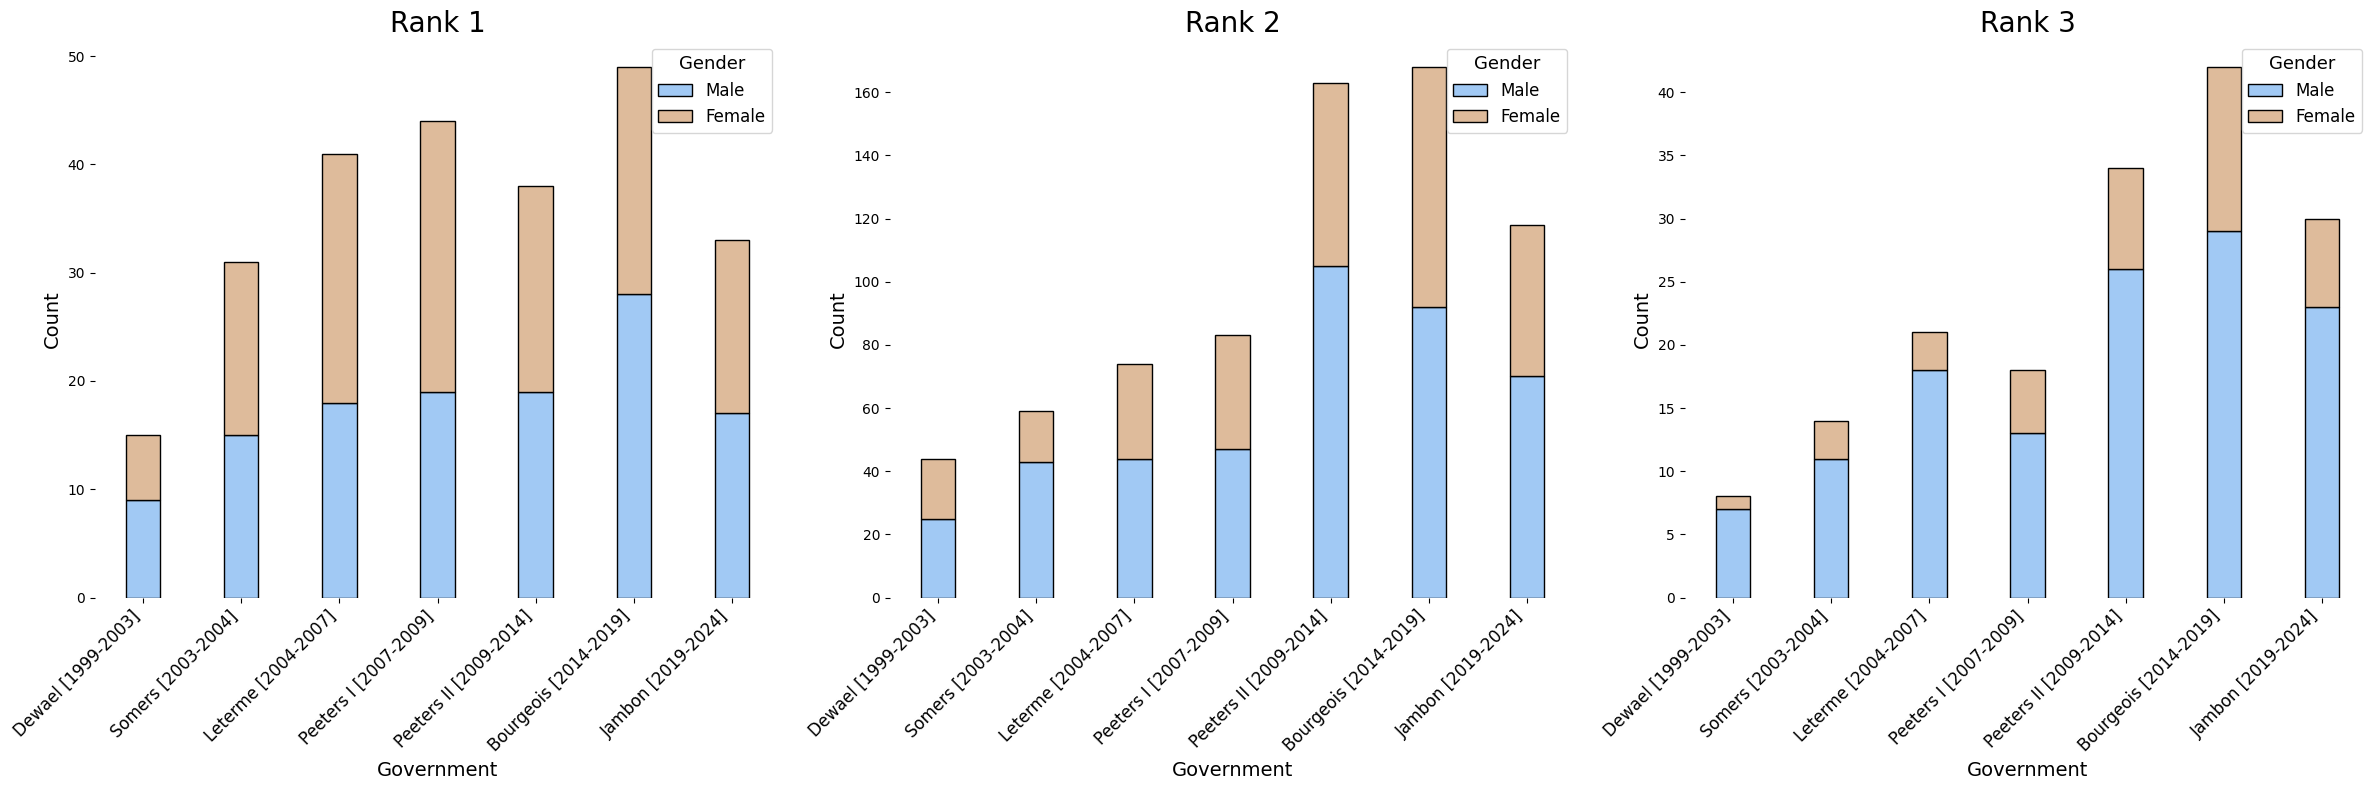

In [ ]:
import ast

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode the 'gov' column
exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']
exploded_gov_df = exploded_gov_df[['adviser_id', 'gov', 'party', 'probability_male', 'mapped_rank']].drop_duplicates()

# Recode 'male_probability' to 'gender'
exploded_gov_df['gender'] = exploded_gov_df['probability_male'].apply(lambda x: 'Male' if x > 0.5 else 'Female')

# Define custom order and labels for governments
gov_order = [1, 2, 3, 4, 5, 6, 8]
gov_labels = ['Dewael [1999-2003]', 'Somers [2003-2004]', 'Leterme [2004-2007]', 'Peeters I [2007-2009]', 'Peeters II [2009-2014]', 'Bourgeois [2014-2019]', 'Jambon [2019-2024]']

# Prepare data for plotting
plot_data = exploded_gov_df.groupby(['gov', 'mapped_rank', 'gender']).size().unstack(fill_value=0).reset_index()

# Colors for gender
colors = {'Male': sns.color_palette("pastel")[0], 'Female': sns.color_palette("pastel")[5]}

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

bar_width = 0.35

for i, rank in enumerate(sorted(plot_data['mapped_rank'].unique())):
    rank_data = plot_data[plot_data['mapped_rank'] == rank]
    male_counts = rank_data['Male'].values if 'Male' in rank_data.columns else [0] * len(rank_data)
    female_counts = rank_data['Female'].values if 'Female' in rank_data.columns else [0] * len(rank_data)

    bar_positions = list(range(len(gov_labels)))

    axes[i].bar(bar_positions, male_counts, bar_width, label='Male', color=colors['Male'], edgecolor='black')
    axes[i].bar(bar_positions, female_counts, bar_width, bottom=male_counts, label='Female', color=colors['Female'], edgecolor='black')

    axes[i].set_title(f'Rank {rank}', fontsize=20)
    axes[i].set_xlabel('Government', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    axes[i].set_xticks(bar_positions)
    axes[i].set_xticklabels(gov_labels, rotation=45, ha='right', fontsize=12)
    axes[i].legend(title='Gender', fontsize=12, title_fontsize='13')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Gender_Hierarchical_Split_per_Government_Rankwise.png')
plt.show()

In [ ]:
def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode the 'gov' column
exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']

# Recode 'male_probability' to 'gender'
exploded_gov_df['gender'] = exploded_gov_df['probability_male'].apply(lambda x: 'Male' if x > 0.5 else 'Female')

# Define custom order and labels for governments
gov_order = [1, 2, 3, 4, 5, 6, 8]
gov_labels = ['Dewael [1999-2003]', 'Somers [2003-2004]', 'Leterme [2004-2007]', 'Peeters I [2007-2009]', 'Peeters II [2009-2014]', 'Bourgeois [2014-2019]', 'Jambon [2019-2024]']

# Prepare data for plotting
plot_data = exploded_gov_df.groupby(['gov', 'mapped_rank', 'gender']).size().unstack(fill_value=0).reset_index()

print(plot_data)

gender  gov  mapped_rank  Female  Male
0         1            1      11     9
1         1            2      19    26
2         1            3       1     8
3         2            1      16    15
4         2            2      17    43
5         2            3       3    12
6         3            1      23    18
7         3            2      32    44
8         3            3       3    18
9         4            1      25    19
10        4            2      37    50
11        4            3       5    13
12        5            1      19    20
13        5            2      68   111
14        5            3      10    30
15        6            1      26    34
16        6            2      91   104
17        6            3      19    39
18        8            1      16    17
19        8            2      52    75
20        8            3       8    25


# Age

In [ ]:
positions_df

,Unnamed: 0.1,Unnamed: 0,pos_id,workplace,start,end,start_year,end_year,ministry_id,match_status,adviser_id,gov,party,probability_male,rank,mapped_rank,estimated_birthyear_x,estimated_birthyear_y,estimated_birthyear,estimated_age
0,0,0,45420,Minister-president van de Vlaamse Regering en ...,2019-01-01,2022-01-01,2019.0,2022.0,45,Unique match,6425,[8],['nva'],0.000000,media,2,1979.0,1979.0,1979.0,40.0
1,1,1,45422,"Cabinet of the Flemish minister for welfare, p...",August 2009,September 2011,2009.0,2011.0,"92,46",Manual review: selected,6429,"[5, 4]",['cdv'],1.000000,adviser,2,1974.0,1974.0,1974.0,35.0
2,2,2,30858,De minister-president van de Vlaamse regering ...,2006-01-01,2006-12-31,2006.0,2006.0,95,Unique match,6436,[3],['cdv'],0.744565,other,1,NaN,NaN,NaN,NaN
3,3,3,38038,Vlaamse Overheid,september 2014,Present,2014.0,2023.0,unknown,Manual review: unknown,6436,[unknown],['unknown'],0.744565,other,1,NaN,NaN,NaN,NaN
4,4,4,38040,Minister-president van de Vlaamse Regering,september 2014,Present,2014.0,2023.0,"29,31",Manual review: selected,6436,[6],['nva'],0.744565,other,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,1240,1234,46221,Viceminister-president van de Vlaamse Regerin...,2010-01-01,2014-12-31,2010.0,2014.0,"[26, 27]",Multiple matches found,9041,[5],['nva'],1.000000,adviser,2,1971.0,1971.0,1971.0,39.0
1241,1241,1235,46226,DEÂ MINISTERÂ PRESIDENTÂ VANÂ DEÂ VLAAMSEÂ RE...,1999-01-01,2003-12-31,1999.0,2003.0,78,Unique match,9073,[1],['vld'],1.000000,other,1,1973.0,1973.0,1973.0,26.0
1242,1242,1236,46254,"Vlaams minister van Mobiliteit, Sociale Econo...",2008-01-01,2009-12-31,2008.0,2009.0,53,Unique match,9182,[4],['spa'],0.000000,other,1,1986.0,1986.0,1986.0,22.0
1243,1243,1237,46268,"Vlaams minister van Onderwijs, Jeugd, Gelijke...",2009-01-01,2013-12-31,2009.0,2013.0,74,Unique match,9252,[5],['spa'],1.000000,adviser,2,1978.0,1978.0,1978.0,31.0


In [ ]:
individuals_df['estimated_age'].count()

576

In [ ]:
positions_df['estimated_age'].median()

33.0

<ipython-input-12-db054dce45c1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=exploded_gov_df, x='gov', y='estimated_age', order=gov_order, palette='pastel')


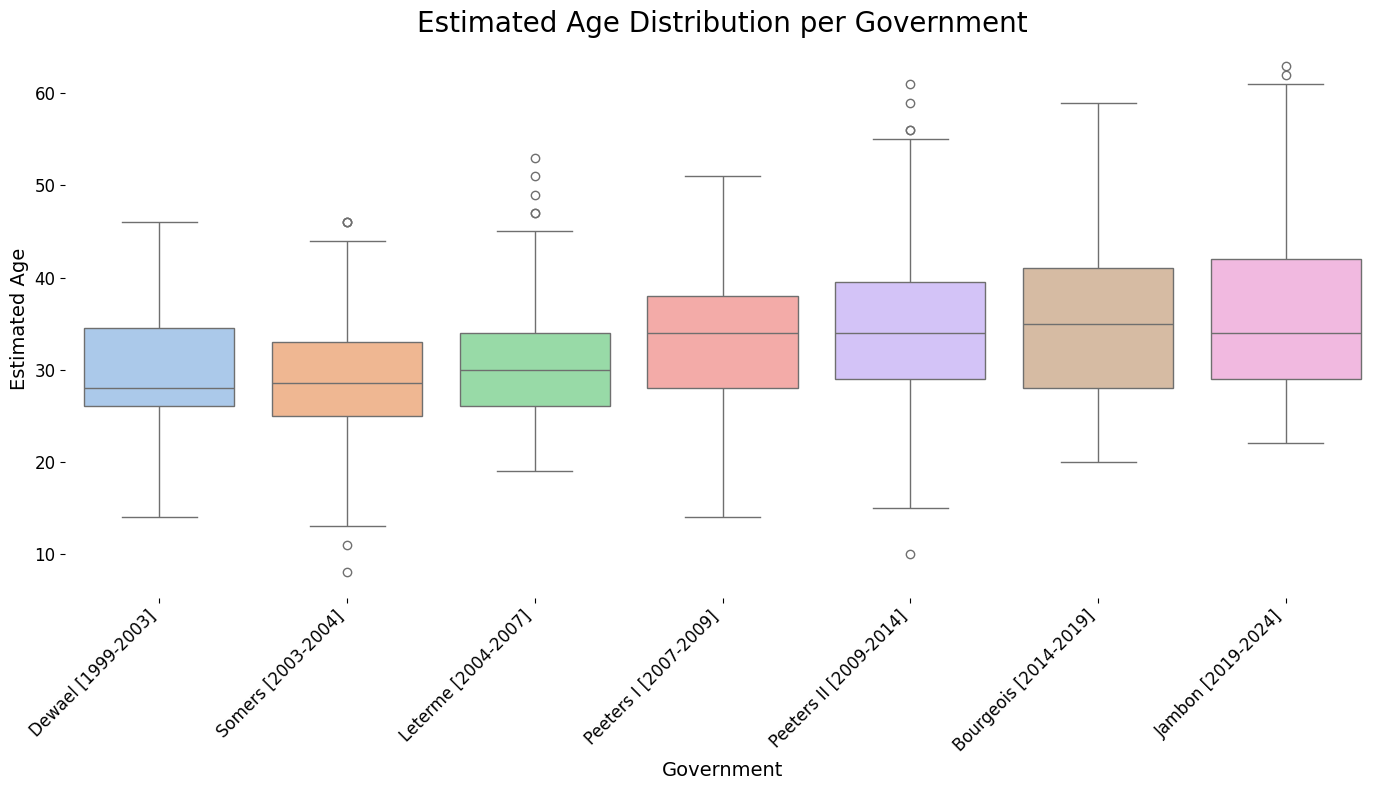

In [ ]:
import ast
# Convert the 'gov' column to a list of integers
def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

positions_df['gov'] = positions_df['gov'].apply(convert_to_list)

# Explode the 'gov' column
exploded_gov_df = positions_df.explode('gov').reset_index(drop=True)
exploded_gov_df = exploded_gov_df[exploded_gov_df['gov'] != 'unknown']


# Define custom order and labels for governments
gov_order = [1, 2, 3, 4, 5, 6, 8]
gov_labels = ['Dewael [1999-2003]', 'Somers [2003-2004]', 'Leterme [2004-2007]', 'Peeters I [2007-2009]', 'Peeters II [2009-2014]', 'Bourgeois [2014-2019]', 'Jambon [2019-2024]']

# Create the box plot for estimated_age across different governments
plt.figure(figsize=(14, 8))
sns.boxplot(data=exploded_gov_df, x='gov', y='estimated_age', order=gov_order, palette='pastel')
plt.title('Estimated Age Distribution per Government', fontsize=20)
plt.xlabel('Government', fontsize=14)
plt.ylabel('Estimated Age', fontsize=14)
plt.xticks(ticks=range(len(gov_labels)), labels=gov_labels, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Estimated_Age_Distribution_per_Government.png')
plt.show()

<ipython-input-14-9ec181954925>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=exploded_gov_df, x='gov', y='estimated_age', order=gov_order, palette='pastel')


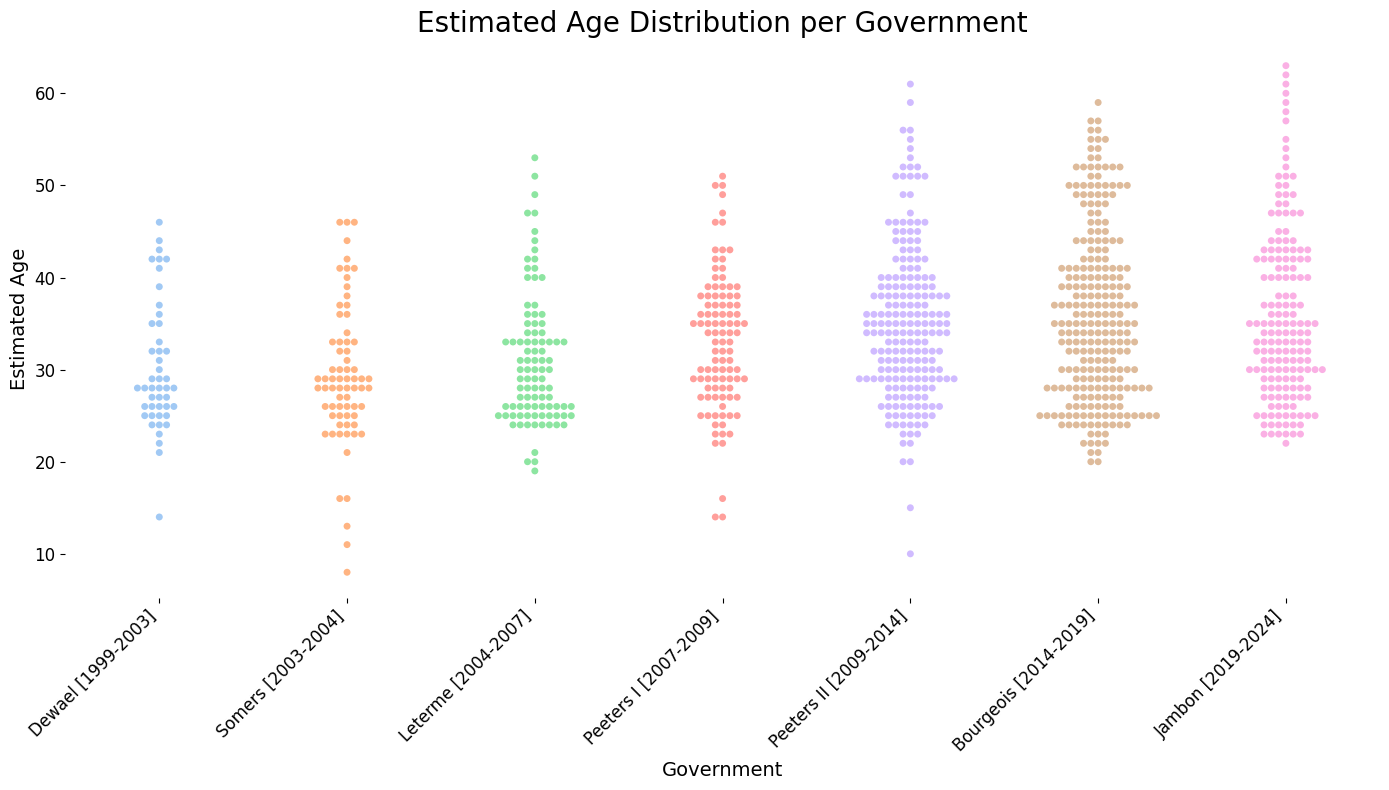

In [ ]:
# Create the swarm plot for estimated_age across different governments
plt.figure(figsize=(14, 8))
sns.swarmplot(data=exploded_gov_df, x='gov', y='estimated_age', order=gov_order, palette='pastel')
plt.title('Estimated Age Distribution per Government', fontsize=20)
plt.xlabel('Government', fontsize=14)
plt.ylabel('Estimated Age', fontsize=14)
plt.xticks(ticks=range(len(gov_labels)), labels=gov_labels, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Estimated_Age_Distribution_per_Government_Swarm.png')
plt.show()

In [ ]:
positions_df.groupby('mapped_rank')['estimated_age'].median()

,estimated_age
mapped_rank,
1,28.0
2,32.0
3,39.5


# Education

In [ ]:
individuals_df_edu['highest_mapped_degree'].value_counts()

,count
highest_mapped_degree,
2.0,516
3.0,69
1.0,47
4.0,23
5.0,19


In [ ]:
# prompt: convert the table from the former cell table into a latex table, take relative counts

import pandas as pd
# Calculate relative counts
relative_counts = individuals_df_edu['highest_mapped_degree'].value_counts(normalize=True) * 100

# Create a DataFrame for the table
df_latex = pd.DataFrame({'Degree': relative_counts.index, 'Percentage': relative_counts.values})

# Format the 'Percentage' column to two decimal places
df_latex['Percentage'] = df_latex['Percentage'].map('{:.2f}'.format)

# Generate the LaTeX table
latex_table = df_latex.to_latex(index=False, caption='Relative Counts of Highest Mapped Degrees', label='tab:degree_counts')

# Print the LaTeX table
print(latex_table)


\begin{table}
\caption{Relative Counts of Highest Mapped Degrees}
\label{tab:degree_counts}
\begin{tabular}{rl}
\toprule
Degree & Percentage \\
\midrule
2.000000 & 76.56 \\
3.000000 & 10.24 \\
1.000000 & 6.97 \\
4.000000 & 3.41 \\
5.000000 & 2.82 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
# prompt: now take the positions_df, take only the positions with mapped_rank 2 and 3, find these individuals in individuals_df_edu by adviser_id and make the same table as in the former cell

import pandas as pd
# Filter positions_df for mapped_rank 2 and 3
filtered_positions = positions_df[positions_df['mapped_rank'].isin([2, 3])]

# Get the adviser_ids for these positions
adviser_ids = filtered_positions['adviser_id'].tolist()

# Filter individuals_df_edu for these adviser_ids
filtered_individuals = individuals_df_edu[individuals_df_edu['adviser_id'].isin(adviser_ids)]

# Calculate relative counts for highest_mapped_degree
relative_counts = filtered_individuals['highest_mapped_degree'].value_counts(normalize=True) * 100

# Create a DataFrame for the table
df_latex = pd.DataFrame({'Degree': relative_counts.index, 'Percentage': relative_counts.values})

# Format the 'Percentage' column to two decimal places
df_latex['Percentage'] = df_latex['Percentage'].map('{:.2f}'.format)

# Generate the LaTeX table
latex_table = df_latex.to_latex(index=False, caption='Relative Counts of Highest Mapped Degrees for Rank 2 and 3', label='tab:degree_counts_rank23')

# Print the LaTeX table
print(latex_table)


\begin{table}
\caption{Relative Counts of Highest Mapped Degrees for Rank 2 and 3}
\label{tab:degree_counts_rank23}
\begin{tabular}{rl}
\toprule
Degree & Percentage \\
\midrule
2.000000 & 81.07 \\
3.000000 & 7.32 \\
1.000000 & 7.14 \\
4.000000 & 2.32 \\
5.000000 & 2.14 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
individuals_df_edu['master_degrees'].value_counts()

,count
master_degrees,
1,324
0,203
2,184
3,32
4,11


In [ ]:
individuals_df_edu['edu_fields'].value_counts()

,count
edu_fields,
['socialScience'],140
['artshum'],103
[],80
['busecon'],65
['law'],49
...,...
"['lifesci', 'socialScience', 'busecon']",1
"['natural', 'artshum']",1
"['na', 'busecon']",1


In [ ]:
# prompt: in educations_df select all columns where degree is master or phd, then make a relative frequecy table of the fields

# Select rows where degree is 'master' or 'phd'
filtered_educations = educations_df[educations_df['degree'].isin(['master', 'phd'])]

# Calculate relative frequencies of fields
field_counts = filtered_educations['field'].value_counts(normalize=True) * 100

# Create a DataFrame for the table
df_latex = pd.DataFrame({'Field': field_counts.index, 'Relative Frequency (%)': field_counts.values})

# Format the 'Relative Frequency (%)' column to two decimal places
df_latex['Relative Frequency (%)'] = df_latex['Relative Frequency (%)'].map('{:.2f}'.format)

# Generate the LaTeX table
latex_table = df_latex.to_latex(index=False, caption='Relative Frequencies of Fields for Master and PhD Degrees', label='tab:field_frequencies')

# Print the LaTeX table
print(latex_table)


\begin{table}
\caption{Relative Frequencies of Fields for Master and PhD Degrees}
\label{tab:field_frequencies}
\begin{tabular}{ll}
\toprule
Field & Relative Frequency (%) \\
\midrule
socialScience & 35.82 \\
artshum & 19.23 \\
busecon & 18.15 \\
law & 17.19 \\
lifesci & 4.93 \\
natural & 3.85 \\
unknown & 0.72 \\
na & 0.12 \\
\bottomrule
\end{tabular}
\end{table}



# Pre-cabinet


In [ ]:
# prompt: in prev_next_df, count the number of elements in the lists (still to be converted from string) in the all_previous column

import ast

def count_elements(value):
  try:
    return len(ast.literal_eval(value))
  except (ValueError, SyntaxError):
    return 0  # Return 0 if the value is not a valid list

prev_next_df['all_previous_count'] = prev_next_df['all_previous'].apply(count_elements)
print(prev_next_df['all_previous_count'].sum())


3074


In [ ]:
prev_next_df['all_previous_count'].mean()

2.666088464874241

In [ ]:
prev_next_df['previous_duration'].mean()

10.323060573857598

In [ ]:
import pandas as pd
import ast

# Helper functions to process input data
def convert_to_dict(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

# Convert columns to appropriate types
prev_next_df['previous_weighted_labels'] = prev_next_df['previous_weighted_labels'].apply(convert_to_dict)
prev_next_df['next_weighted_labels'] = prev_next_df['next_weighted_labels'].apply(convert_to_dict)
prev_next_df['gov_x'] = prev_next_df['gov_x'].apply(convert_to_list)

# Replace empty lists with specific labels
prev_next_df['previous_weighted_labels'] = prev_next_df['previous_weighted_labels'].apply(lambda x: {'No Previous Jobs': 1.0} if not x else x)
prev_next_df['next_weighted_labels'] = prev_next_df['next_weighted_labels'].apply(lambda x: {'No Next': 1.0} if not x else x)

# Explode the DataFrame by 'gov'
exploded_df = prev_next_df.explode('gov_x').reset_index(drop=True)

# Exclude rows where gov is unknown
exploded_df = exploded_df[exploded_df['gov_x'] != 'unknown']

# Function to categorize labels into groups
def categorize_label(label):
    if 'politics' in label.lower():
        return 'Public Sector (Politics)'
    elif label.lower() == 'public':
        return 'Public Sector (Non-Politics)'
    elif label.lower() in ['judiciary', 'board', 'semiprivate']:
        return 'Other'
    elif label.lower() in ['no previous jobs', 'unknown', 'other']:
        return 'Other'
    else:
        return 'Private Sector/Other'

# Initialize dictionaries for counts
weighted_counts_previous_per_gov = {}
global_weighted_counts_previous = {}

# Process each row for 'previous_weighted_labels'
for idx, row in exploded_df.iterrows():
    previous_labels = row['previous_weighted_labels']
    gov = row['gov_x']

    if isinstance(previous_labels, dict):
        for label, weight in previous_labels.items():
            category = categorize_label(label)

            # Update global counts
            if category not in global_weighted_counts_previous:
                global_weighted_counts_previous[category] = {}
            # For judiciary, board, and semiPrivate, aggregate their counts into 'other'
            if category == 'Other' and label in ['judiciary', 'board', 'semiprivate']:
                label = 'other'
            if label not in global_weighted_counts_previous[category]:
                global_weighted_counts_previous[category][label] = 0
            global_weighted_counts_previous[category][label] += weight

            # Update government-specific counts
            if gov not in weighted_counts_previous_per_gov:
                weighted_counts_previous_per_gov[gov] = {}
            if category not in weighted_counts_previous_per_gov[gov]:
                weighted_counts_previous_per_gov[gov][category] = {}
            if label not in weighted_counts_previous_per_gov[gov][category]:
                weighted_counts_previous_per_gov[gov][category][label] = 0
            weighted_counts_previous_per_gov[gov][category][label] += weight

# Prepare a list to hold rows of the DataFrame
rows = []

# Calculate the total counts per government
gov_totals_previous = pd.Series({gov: sum(sum(label_weights.values()) for label_weights in gov_data.values()) for gov, gov_data in weighted_counts_previous_per_gov.items()})

# Create DataFrame for previous labels
for category, labels in global_weighted_counts_previous.items():
    # Calculate and append subtotal row for the category
    subtotal_percentage = round(sum(global_weighted_counts_previous[category].values()) / sum([sum(labels.values()) for labels in global_weighted_counts_previous.values()]) * 100, 2)
    subtotal_row = [
        f"{category} Subtotal",
        subtotal_percentage
    ] + [
        round(sum(weighted_counts_previous_per_gov[gov][category].values()) / gov_totals_previous[gov] * 100, 2)
        if category in weighted_counts_previous_per_gov[gov] else 0
        for gov in sorted(weighted_counts_previous_per_gov.keys())
    ]
    rows.append(subtotal_row)

    # Append rows for each label under the category
    for label, global_count in labels.items():
        global_percentage = round(global_count / sum([sum(labels.values()) for labels in global_weighted_counts_previous.values()]) * 100, 2)
        row = [
            f"  {label}",
            global_percentage
        ] + [
            round(weighted_counts_previous_per_gov[gov][category][label] / gov_totals_previous[gov] * 100, 2)
            if gov in weighted_counts_previous_per_gov and category in weighted_counts_previous_per_gov[gov] and label in weighted_counts_previous_per_gov[gov][category] else 0
            for gov in sorted(weighted_counts_previous_per_gov.keys())
        ]
        rows.append(row)

# Convert rows to a DataFrame
columns = ['Label', 'Global Frequency (%)'] + [f'Gov {gov} (n={gov_totals_previous[gov]:.2f})' for gov in sorted(weighted_counts_previous_per_gov.keys())]
relative_label_counts_df_previous = pd.DataFrame(rows, columns=columns)

# Display the DataFrame for previous labels
print("Relative Previous Labels Count per Government and Globally with Subtotals:")
print(relative_label_counts_df_previous)

# Export to LaTeX for previous labels (optional)
print("\nRelative Previous Labels LaTeX:")
print(relative_label_counts_df_previous.to_latex(index=False))

# Repeat the same steps for the 'next_weighted_labels'

# Initialize dictionaries for next labels
weighted_counts_next_per_gov = {}
global_weighted_counts_next = {}

# Process each row for 'next_weighted_labels'
for idx, row in exploded_df.iterrows():
    next_labels = row['next_weighted_labels']
    gov = row['gov_x']

    if isinstance(next_labels, dict):
        for label, weight in next_labels.items():
            category = categorize_label(label)

            # Update global counts
            if category not in global_weighted_counts_next:
                global_weighted_counts_next[category] = {}
            # For judiciary, board, and semiPrivate, aggregate their counts into 'other'
            if category == 'Other' and label in ['judiciary', 'board', 'semiprivate']:
                label = 'other'
            if label not in global_weighted_counts_next[category]:
                global_weighted_counts_next[category][label] = 0
            global_weighted_counts_next[category][label] += weight

            # Update government-specific counts
            if gov not in weighted_counts_next_per_gov:
                weighted_counts_next_per_gov[gov] = {}
            if category not in weighted_counts_next_per_gov[gov]:
                weighted_counts_next_per_gov[gov][category] = {}
            if label not in weighted_counts_next_per_gov[gov][category]:
                weighted_counts_next_per_gov[gov][category][label] = 0
            weighted_counts_next_per_gov[gov][category][label] += weight

# Prepare a list to hold rows of the DataFrame
rows = []

# Calculate the total counts per government
gov_totals_next = pd.Series({gov: sum(sum(label_weights.values()) for label_weights in gov_data.values()) for gov, gov_data in weighted_counts_next_per_gov.items()})

# Create DataFrame for next labels
for category, labels in global_weighted_counts_next.items():
    # Calculate and append subtotal row for the category
    subtotal_percentage = round(sum(global_weighted_counts_next[category].values()) / sum([sum(labels.values()) for labels in global_weighted_counts_next.values()]) * 100, 2)
    subtotal_row = [
        f"{category} Subtotal",
        subtotal_percentage
    ] + [
        round(sum(weighted_counts_next_per_gov[gov][category].values()) / gov_totals_next[gov] * 100, 2)
        if category in weighted_counts_next_per_gov[gov] else 0
        for gov in sorted(weighted_counts_next_per_gov.keys())
    ]
    rows.append(subtotal_row)

    # Append rows for each label under the category
    for label, global_count in labels.items():
        global_percentage = round(global_count / sum([sum(labels.values()) for labels in global_weighted_counts_next.values()]) * 100, 2)
        row = [
            f"  {label}",
            global_percentage
        ] + [
            round(weighted_counts_next_per_gov[gov][category][label] / gov_totals_next[gov] * 100, 2)
            if gov in weighted_counts_next_per_gov and category in weighted_counts_next_per_gov[gov] and label in weighted_counts_next_per_gov[gov][category] else 0
            for gov in sorted(weighted_counts_next_per_gov.keys())
        ]
        rows.append(row)

# Convert rows to a DataFrame
columns = ['Label', 'Global Frequency (%)'] + [f'Gov {gov} (n={gov_totals_next[gov]:.2f})' for gov in sorted(weighted_counts_next_per_gov.keys())]
relative_label_counts_df_next = pd.DataFrame(rows, columns=columns)

# Display the DataFrame for next labels
print("Relative Next Labels Count per Government and Globally with Subtotals:")
print(relative_label_counts_df_next)

# Export to LaTeX for next labels (optional)
print("\nRelative Next Labels LaTeX:")
print(relative_label_counts_df_next.to_latex(index=False))


Relative Previous Labels Count per Government and Globally with Subtotals:
                                    Label  Global Frequency (%)  \
0           Private Sector/Other Subtotal                 36.68   
1                                 private                 13.68   
2                                civilsoc                 10.71   
3                             internatOrg                  2.15   
4                                   media                  2.71   
5                                academia                  7.42   
6   Public Sector (Non-Politics) Subtotal                 17.32   
7                                  public                 17.32   
8       Public Sector (Politics) Subtotal                 24.80   
9                           politics(gov)                 13.83   
10                          politics(leg)                  3.65   
11                        politics(local)                  1.85   
12                        politics(centr)             

In [ ]:
import pandas as pd
import ast

# Helper functions to process input data
def convert_to_dict(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return [value]

# Convert columns to appropriate types
prev_next_df['previous_weighted_labels'] = prev_next_df['previous_weighted_labels'].apply(convert_to_dict)
prev_next_df['next_weighted_labels'] = prev_next_df['next_weighted_labels'].apply(convert_to_dict)
prev_next_df['gov_x'] = prev_next_df['gov_x'].apply(convert_to_list)

# Replace empty lists with specific labels
prev_next_df['previous_weighted_labels'] = prev_next_df['previous_weighted_labels'].apply(lambda x: {'No Previous Jobs': 1.0} if not x else x)
prev_next_df['next_weighted_labels'] = prev_next_df['next_weighted_labels'].apply(lambda x: {'No Next': 1.0} if not x else x)

# Explode the DataFrame by 'gov'
exploded_df = prev_next_df.explode('gov_x').reset_index(drop=True)

# Exclude rows where gov is unknown
exploded_df = exploded_df[exploded_df['gov_x'] != 'unknown']

# Function to categorize labels into groups
def categorize_label(label):
    if 'politics' in label.lower():
        return 'Public Sector (Politics)'
    elif label.lower() == 'public':
        return 'Public Sector (Non-Politics)'
    elif label.lower() == 'judiciary':
        return 'Other'
    elif label.lower() == 'semiprivate':
        return 'Other'  # semiPrivate is now part of the 'other' subcategory
    elif label.lower() == 'board':
        return 'Private Sector/Other'  # board is now part of Private Sector/Other
    elif label.lower() in ['no next', 'no previous jobs', 'unknown', 'other']:
        return 'Other'  # "No Next" moved to "Other"
    else:
        return 'Private Sector/Other'

# Initialize dictionaries for counts
weighted_counts_next_per_gov = {}
global_weighted_counts_next = {}

# Process each row for 'next_weighted_labels'
for idx, row in exploded_df.iterrows():
    next_labels = row['next_weighted_labels']
    gov = row['gov_x']

    if isinstance(next_labels, dict):
        for label, weight in next_labels.items():
            category = categorize_label(label)

            # Update global counts
            if category not in global_weighted_counts_next:
                global_weighted_counts_next[category] = {}
            # Aggregate specific labels into appropriate subcategories
            if category == 'Other' and label in ['judiciary', 'semiPrivate', 'no next']:
                label = 'other'
            if label not in global_weighted_counts_next[category]:
                global_weighted_counts_next[category][label] = 0
            global_weighted_counts_next[category][label] += weight

            # Update government-specific counts
            if gov not in weighted_counts_next_per_gov:
                weighted_counts_next_per_gov[gov] = {}
            if category not in weighted_counts_next_per_gov[gov]:
                weighted_counts_next_per_gov[gov][category] = {}
            if label not in weighted_counts_next_per_gov[gov][category]:
                weighted_counts_next_per_gov[gov][category][label] = 0
            weighted_counts_next_per_gov[gov][category][label] += weight

# Prepare a list to hold rows of the DataFrame
rows = []

# Calculate the total counts per government
gov_totals_next = pd.Series({gov: sum(sum(label_weights.values()) for label_weights in gov_data.values()) for gov, gov_data in weighted_counts_next_per_gov.items()})

# Create DataFrame for next labels
for category, labels in global_weighted_counts_next.items():
    # Calculate and append subtotal row for the category
    subtotal_percentage = round(sum(global_weighted_counts_next[category].values()) / sum([sum(labels.values()) for labels in global_weighted_counts_next.values()]) * 100, 2)
    subtotal_row = [
        f"{category} Subtotal",
        subtotal_percentage
    ] + [
        round(sum(weighted_counts_next_per_gov[gov][category].values()) / gov_totals_next[gov] * 100, 2)
        if category in weighted_counts_next_per_gov[gov] else 0
        for gov in sorted(weighted_counts_next_per_gov.keys())
    ]
    rows.append(subtotal_row)

    # Append rows for each label under the category
    for label, global_count in labels.items():
        global_percentage = round(global_count / sum([sum(labels.values()) for labels in global_weighted_counts_next.values()]) * 100, 2)
        row = [
            f"  {label}",
            global_percentage
        ] + [
            round(weighted_counts_next_per_gov[gov][category][label] / gov_totals_next[gov] * 100, 2)
            if gov in weighted_counts_next_per_gov and category in weighted_counts_next_per_gov[gov] and label in weighted_counts_next_per_gov[gov][category] else 0
            for gov in sorted(weighted_counts_next_per_gov.keys())
        ]
        rows.append(row)

# Convert rows to a DataFrame
columns = ['Label', 'Global Frequency (%)'] + [f'Gov {gov} (n={gov_totals_next[gov]:.2f})' for gov in sorted(weighted_counts_next_per_gov.keys())]
relative_label_counts_df_next = pd.DataFrame(rows, columns=columns)

# Display the DataFrame for next labels
print("Relative Next Labels Count per Government and Globally with Subtotals:")
print(relative_label_counts_df_next)

# Export to LaTeX for next labels (optional)
print("\nRelative Next Labels LaTeX:")
print(relative_label_counts_df_next.to_latex(index=False))

Relative Next Labels Count per Government and Globally with Subtotals:
                                    Label  Global Frequency (%)  \
0           Private Sector/Other Subtotal                 36.20   
1                                civilsoc                 11.94   
2                                 private                 12.29   
3                                academia                  3.65   
4                                   media                  0.83   
5                                   board                  5.94   
6                             internatOrg                  1.55   
7   Public Sector (Non-Politics) Subtotal                 24.91   
8                                  public                 24.91   
9                          Other Subtotal                 12.82   
10                                No Next                 11.53   
11                                unknown                  0.28   
12                                  other                 

In [ ]:
# prompt: make a new column in prev_next_df counting the number of elements in lists in the all_next column. These lists are probably strings so convert them first

def count_elements(value):
  try:
    return len(ast.literal_eval(value))
  except (ValueError, SyntaxError):
    return 0  # Return 0 if the value is not a valid list

prev_next_df['all_next_count'] = prev_next_df['all_next'].apply(count_elements)


In [ ]:
print(prev_next_df['all_next_count'].sum())
prev_next_df['all_next_count'].mean()

3902


3.3842150910667823